# Figure 5: Eigenvalue Distribution of a Large Random Network

## Introduction
In this notebook, we analyse how the eigenvalue distribution changes with network size.

***

## Code
### 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

### 2. Define Functions

First, we define the random matrix generating function *gen_matrix_F()* with parameters *n* (network size) and *vr* (variance).

In [2]:
def gen_matrix_F(n,vr):
    I = np.eye(n)
    mu = 0
    B = mu + np.sqrt(vr) * np.random.randn(n, n)
    np.fill_diagonal(B, 0)
    A = -I + B
    D = np.zeros((n, n))
    return A, D

Next, we define a function that performs linear stability analysis and computes the Turing I percentage.

In [3]:
def process_matrices(n, vr):

  D = gen_matrix_F(n, vr)[1]         # diagonal matrix
  D[0, 0] = 1
  D[1, 1] = 10
  k = np.arange(0, 101, 0.2)

  t1a = []
  t1b = []
  t2a = []
  t2b = []

  t1ar = []
  t1ai = []
  t1br = []
  t1bi = []
  t2ar = []
  t2ai = []
  t2br = []
  t2bi = []

  t1ars = []
  t1ais = []
  t1brs = []
  t1bis = []

  wavelength = []

# check for first succesfull case
  t1ar_t = True
  t1ai_t = True
  t1br_t = True
  t1bi_t = True
  wvl_cond = True

  for i in range(500):
    m = gen_matrix_F(n,vr)[0]
    ev = np.linalg.eigvals(m)
    if np.max(np.real(ev)) < 0: # if matrix is stable
      Em = []
      Emi = []
      real_e = []
      img_e = []
      kn = []
      for i in range(len(k)):
          R = m - D * (k[i] ** 2)
          eigval = np.linalg.eigvals(R)
          Em.append(np.max(np.real(eigval)))
          idx_max = np.argmax(np.real(eigval))
          Emi.append(np.imag(eigval[idx_max]))
          real_e.extend(np.real(eigval))
          img_e.extend(np.imag(eigval))
          if k[i] < 1:
              kn.extend(["< 1"]*len(np.real(eigval)))
          elif k[i] == 1:
              kn.extend(["1"]*len(np.real(eigval)))
          else:
              kn.extend(["> 1"]*len(np.real(eigval)))
      a = np.max(Em)
      index = np.argmax(Em)
      nEm = np.array(Em)
      if a > 0:
          if Emi[index] == 0:
              numZeroCrossing = np.count_nonzero(np.diff(np.sign(Em)))                        # Count zero crossings
              numpositivelocalmaxima = np.sum(nEm[argrelextrema(nEm,np.greater)]>0) > 0       # Count positive local maxima
              if numpositivelocalmaxima > 0 and numZeroCrossing % 2 == 0:                     # condition for type 1a instability
                  t1a.append(m)
                  t1ar.extend(Em)
                  t1ai.extend(Emi)
                  if t1ar_t:
                      t1ars.extend(real_e)
                      t1ar_t = False
                  if t1ai_t:
                      t1ais.extend(img_e)
                      t1ai_t = False
                  if wvl_cond:
                      wavelength.extend(kn)
                      wvl_cond = False

              elif numpositivelocalmaxima > 0 and numZeroCrossing == 1:                       # condition for type 1b instability
                  t1b.append(m)
                  t1br.extend(Em)
                  t1bi.extend(Emi)
                  if t1br_t:
                      t1brs.extend(real_e)
                      t1br_t = False
                  if t1bi_t:
                      t1bis.extend(img_e)
                      t1bi_t = False
                  if wvl_cond:
                      wavelength.extend(kn)
                      wvl_cond = False
              elif numpositivelocalmaxima == 0 and numZeroCrossing % 2 == 1:                  # condition for type 2a instability
                  t2a.append(m)
                  t2ar.extend(Em)
                  t2ai.extend(Emi)
              elif numpositivelocalmaxima > 0 and numZeroCrossing % 2 == 1:                   # condition for type 2b instability
                  t2b.append(m)
                  t2br.extend(Em)
                  t2bi.extend(Emi)

  data_dict = {'Re(\u03bb\u2096)': t1ars, 'Im(\u03bb\u2096)': t1ais,'K': wavelength}
  df = pd.DataFrame(data_dict)

  return df

### 3. Generate and Process Data

In this example, we compute the eigenvalues for *N* = 100 and $σ^2$ = 0.01.

In [4]:
n = 100
var = 0.01

data = process_matrices(n, var)

def transform_value(value):
    if value == '1':
        return 'k = 1'
    elif value == '< 1':
        return 'k < 1'
    elif value == '> 1':
        return 'k > 1'
    else:
        return value

data['K'] = data['K'].apply(transform_value)

data.head()

,Re(λₖ),Im(λₖ),K
0,-0.276561,0.691614,k < 1
1,-0.276561,-0.691614,k < 1
2,-0.002582,0.000000,k < 1
3,-0.662261,0.922614,k < 1
4,-0.662261,-0.922614,k < 1


### 4. Visualise Data

First, we plot the scatter plot of eigenvalue distribution in the complex plain for *N* = 100, $σ^2$ = 0.01. The diffusion constants are $D_1$ = 1, $D_2$ = 10. The corresponding kernel density estimations are also plotted.

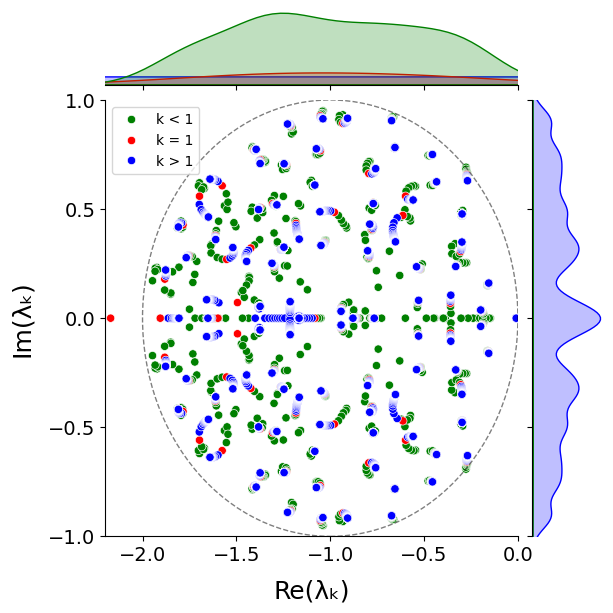

In [5]:
import matplotlib.patches as patches

custom_palette = {'k = 1': 'red', 'k > 1': 'blue', 'k < 1': 'green'}
g = sns.jointplot(data=data, x='Re(\u03bb\u2096)', y='Im(\u03bb\u2096)',hue='K', legend=True, ylim=(-1,1), xlim=(-2.2,0), palette=custom_palette)
g.set_axis_labels('Re(\u03bb\u2096)', 'Im(\u03bb\u2096)', fontsize=18, labelpad=10)
#g.ax_joint.set_xticks([-2, -1.5, -1, -0.5, 0])
g.ax_joint.set_yticks([-1, -0.5, 0, 0.5, 1])
g.ax_joint.set_xticks([-2, -1.5, -1, -0.5, 0])

circle = patches.Circle((-1, 0), radius=1, edgecolor='black', facecolor='none', linestyle='dashed', alpha=0.5)
g.ax_joint.add_patch(circle)
g.ax_joint.tick_params(axis='both', which='major', labelsize=14)
plt.legend(title=None)
plt.show()

Next, we plot the full eigenvalue distribution.

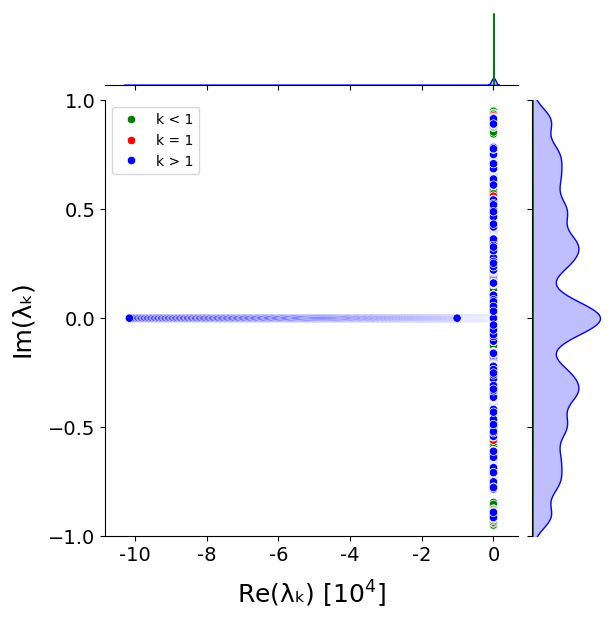

In [7]:
g = sns.jointplot(data=data, x='Re(\u03bb\u2096)', y='Im(\u03bb\u2096)',hue='K', legend=True, ylim=(-1,1), palette=custom_palette)
g.set_axis_labels('Re(\u03bb\u2096) [$10^4$]', 'Im(\u03bb\u2096)', fontsize=18,labelpad=10)
g.ax_joint.set_yticks([-1, -0.5, 0, 0.5, 1])
plt.xticks([-100000,-80000,-60000,-40000,-20000,0], [-10,-8,-6,-4,-2,0])
g.ax_joint.tick_params(axis='both', which='major', labelsize=14)
plt.legend(title=None)
plt.show()